# Evaluate Trained PIP-NN

## Load Model

We have saved the PIP-NN model for NaOH system as `NaOH-PIP-NN-model.pth`. First, we will load this model.

In [3]:
import torch

model = torch.load("NaOH-PIP-NN-model.pth")
# here we invoke this model on CPU
device = torch.device("cpu")
model.to("cpu")
model

PIP_NN(
  (layer_stack): Sequential(
    (0): Linear(in_features=34, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

## Load Data

In [4]:
from openbabel import pybel
from MZMol import MZMol
import numpy as np

In [5]:
X_train_tensor = torch.from_numpy(np.loadtxt("X_train.txt"))
X_valid_tensor = torch.from_numpy(np.loadtxt("X_valid.txt"))
Y_train_tensor = torch.from_numpy(np.loadtxt("Y_train.txt").reshape(-1, 1))
Y_valid_tensor = torch.from_numpy(np.loadtxt("Y_valid.txt").reshape(-1, 1))

X_train_tensor.shape, X_valid_tensor.shape, Y_train_tensor.shape, Y_valid_tensor.shape

(torch.Size([12720, 34]),
 torch.Size([3181, 34]),
 torch.Size([12720, 1]),
 torch.Size([3181, 1]))

## Min Max Normalization 

In [6]:
def scale(t: torch.Tensor, t_min: torch.Tensor, t_max: torch.Tensor) -> torch.Tensor:
    return 2 * (t - t_min) / (t_max - t_min) - 1

X_min_tensor = torch.from_numpy(np.loadtxt("X_min.txt"))
X_max_tensor = torch.from_numpy(np.loadtxt("X_max.txt"))

X_scaled_train_tensor = scale(X_train_tensor, X_min_tensor, X_max_tensor)
X_scaled_valid_tensor = scale(X_valid_tensor, X_min_tensor, X_max_tensor)

Y_min_tensor = torch.from_numpy(np.loadtxt("Y_min.txt"))
Y_max_tensor = torch.from_numpy(np.loadtxt("Y_max.txt"))

Y_scaled_train_tensor = scale(Y_train_tensor, Y_min_tensor, Y_max_tensor)
Y_scaled_valid_tensor = scale(Y_valid_tensor, Y_min_tensor, Y_max_tensor)

## Call Model

We pass the scaled data to model, NEVER forget to inverse scale the output of model!

$$
T = \frac{1}{2} (T_\text{scaled} + 1) (T_\text{max} - T_\text{min}) + T_\text{min}
$$

In [9]:
# call model
Y_scaled_train_pred_tensor = model(X_scaled_train_tensor.float())
Y_scaled_valid_pred_tensor = model(X_scaled_valid_tensor.float())

# inverse transform
def inverse_scale(t: torch.Tensor, t_min: torch.Tensor, t_max: torch.Tensor):
    res = (t + 1) * (t_max - t_min) * 0.5 + t_min
    return res

Y_pred_train_tensor = inverse_scale(Y_scaled_train_pred_tensor, Y_min_tensor, Y_max_tensor)
Y_pred_valid_tensor = inverse_scale(Y_scaled_valid_pred_tensor, Y_min_tensor, Y_max_tensor)

## Errors

Here we compute 3 different errors:

1. MAE

$$
\mathrm{MAE} = \frac{1}{n} \sum_{i = 1}^{n} | y_i - f(x_i) |
$$

2. MSE

$$
\mathrm{MSE} = \frac{1}{n} \sum_{i = 1}^{n} {(y_i - f(x_i))}^2
$$

3. RMSE

$$
\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} {(y_i - f(x_i))}^2}
$$

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

In [11]:
# concatenate E_train and E_valid as E_total
E_train = Y_train_tensor.detach().numpy()
E_valid = Y_valid_tensor.detach().numpy()

E_pred_train = Y_pred_train_tensor.detach().numpy()
E_pred_valid = Y_pred_valid_tensor.detach().numpy()

E_total = np.concatenate((E_train, E_valid))
E_pred_total = np.concatenate((E_pred_train, E_pred_valid))

MAE_train = mean_absolute_error(E_train, E_pred_train)
MAE_valid = mean_absolute_error(E_valid, E_pred_valid)
MAE_total = mean_absolute_error(E_total, E_pred_total)

In [12]:
MSE_train = mean_squared_error(E_train, E_pred_train)
MSE_valid = mean_squared_error(E_valid, E_pred_valid)
MSE_total = mean_squared_error(E_total, E_pred_total)

In [13]:
RMSE_train = np.sqrt(MSE_train)
RMSE_valid = np.sqrt(MSE_valid)
RMSE_total = np.sqrt(MSE_total)

In [14]:
df_err = pd.DataFrame({
    "Dataset": [
        "train",
        "valid",
        "total"
    ],
    "MAE": [
        MAE_train,
        MAE_valid,
        MAE_total
    ],
    "MSE": [
        MSE_train,
        MSE_valid,
        MSE_total
    ],
    "RMSE": [
        RMSE_train,
        RMSE_valid,
        RMSE_total
    ]
})

df_err.to_csv("NaOH-PIP-NN-Error.csv")
df_err

,Dataset,MAE,MSE,RMSE
0,train,0.011352,0.000293,0.017106
1,valid,0.011569,0.000289,0.016992
2,total,0.011395,0.000292,0.017084


## Absolute Error Distribution

In [15]:
from matplotlib import pyplot as plt

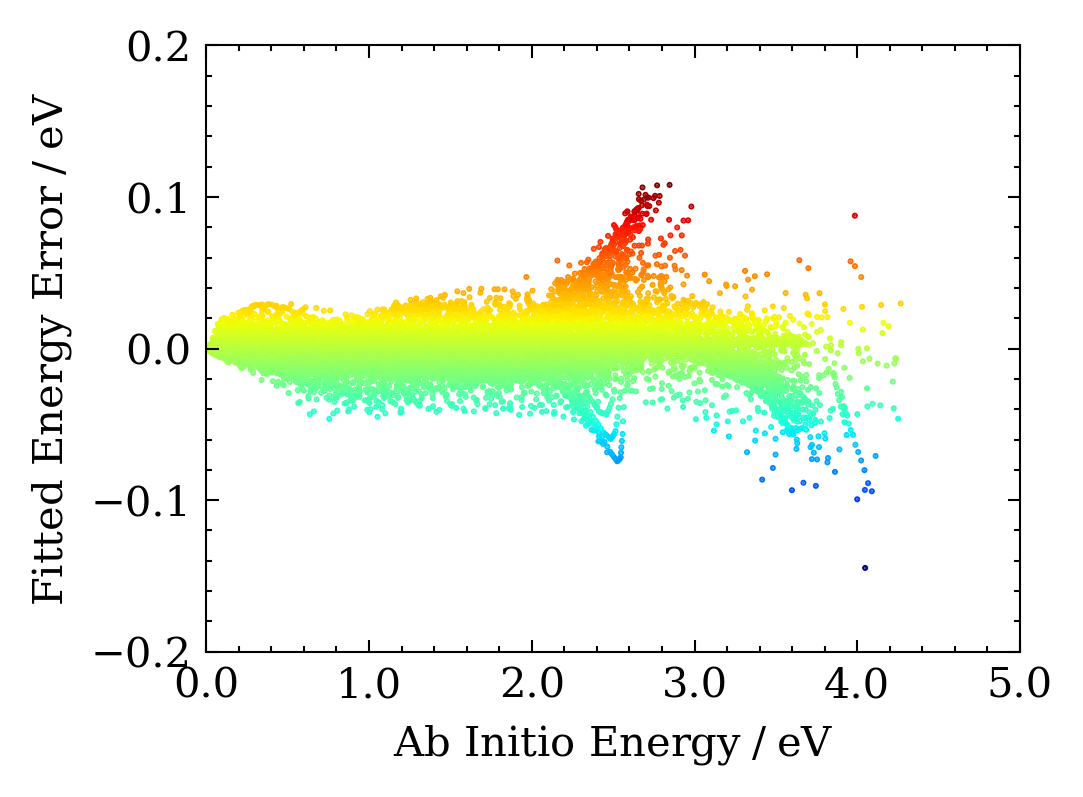

In [16]:
%matplotlib inline

E_err_total = E_pred_total - E_total

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111)

    ax.scatter(E_total, E_err_total, s=0.2, c=E_err_total, cmap=plt.cm.jet)
    ax.set_xlabel(r"$\mathrm{Ab \ Initio \ Energy \; / \; eV}$")
    xticks = np.arange(0, 5.5)
    ax.set_xticks(xticks)
    ax.set_xlim([0, 5.0])
    ax.set_xticklabels([f"{x:.1f}" for x in xticks])

    ax.set_ylabel(r"$\mathrm{Fitted \ Energy \ Error \; / \; eV}$")
    ax.set_ylim([-0.2, 0.2])

## Congratulations!

You have trained your own PIP-NN model for $\mathrm{NaOH}$ System! Maybe you can try it out with molecular dynamics softwares!